In [1]:
!pip install transformers #installing because we want to use pre_trained models, both from huggingface and our own models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import torch
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/ESC324projectdrive/dav/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Simplify the code by creating a function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the pickle files using the function
neg_list_processed = load_pickle(base_dir + 'neg_list_processed.pickle')
het_list_processed = load_pickle(base_dir + 'het_list_processed.pickle')
homo_list_processed = load_pickle(base_dir + 'homo_list_processed.pickle')
rel_freq = load_pickle(base_dir + 'tag_dict.pickle')

In [5]:
print(rel_freq)

{'': 0.0003436426116838488, "''": 0.0003436426116838488, ',': 0.0003436426116838488, '-LRB-': 0.0003436426116838488, '-RRB-': 0.0003436426116838488, '.': 0.0003436426116838488, ':': 0.0003436426116838488, 'CC': 0.0003436426116838488, 'CD': 0.0010309278350515464, 'DT': 0.0003436426116838488, 'EX': 0.0003436426116838488, 'FW': 0.0006872852233676976, 'HYPH': 0.0003436426116838488, 'IN': 0.0024054982817869417, 'JJ': 0.11134020618556702, 'JJR': 0.0013745704467353953, 'JJS': 0.0013745704467353953, 'LS': 0.0003436426116838488, 'MD': 0.0013745704467353953, 'NFP': 0.0003436426116838488, 'NN': 0.3518900343642612, 'NNP': 0.07835051546391752, 'NNPS': 0.0013745704467353953, 'NNS': 0.09725085910652921, 'PDT': 0.0003436426116838488, 'POS': 0.0003436426116838488, 'PRP': 0.0006872852233676976, 'PRP$': 0.0003436426116838488, 'RB': 0.06632302405498282, 'RBR': 0.0006872852233676976, 'RBS': 0.0003436426116838488, 'RP': 0.001718213058419244, 'TO': 0.0003436426116838488, 'UH': 0.002061855670103093, 'VB': 0.0

In [6]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

mega_list = homo_list_processed + het_list_processed
#shuffling the list
random.shuffle(mega_list)


In [7]:
#mega_list is a giant list where each sublist of the following format:
#[['in/IN', 'the/DT', 'room/NN', 'the/DT', 'curtain/NNS', 'be/VBD', 'draw/VBN', ',/,', 'but/CC', 'the/DT', 'rest/NN', 'of/IN', 'the/DT', 'furniture/NN', 'be/VBD', 'real/JJ', './.'], ['In', 'the', 'room', 'the', 'curtains', 'were', 'drawn', ',', 'but', 'the', 'rest', 'of', 'the', 'furniture', 'was', 'real', '.'], ['draw/VBN']]. the first subsublist in the sublist is contains words in a sentence that have been POS tagged, second subsublist containts the original sentence, and third subsublist contains the pun word that has been POS tagged. Write code to tokenize this data, and fine tune a pretrained RoBERTa model to predict location of puns

input_sentences = [sublist[1] for sublist in mega_list]
pos_sentences = [sublist[0] for sublist in mega_list]
pun_words = [sublist[2][0] for sublist in mega_list]

#calculating the max len for padding the inputs
max_len = 0
longest_joke = ""
for sentence in input_sentences:
  if len(sentence) > max_len:
    max_len = len(sentence)
    longest_joke = " ".join(sentence) 
print("Largest sentence in dataset has lenght = ", max_len)
print("This joke is:\n", longest_joke)

#creating an array of heuristic based on rel_freq mapping for each tag in dataset
rel_freq_heuristic = []
for sentence in pos_sentences:
  temp_heuristic = []
  for word in sentence:
    temp_heuristic.append(rel_freq.get(word.split("/")[1], 0))
  temp_heuristic += [0]*(max_len - len(temp_heuristic))
  rel_freq_heuristic.append(temp_heuristic)
rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

input_ids = []
attention_masks = []
labels = []

for sentence, pun_word, pos_sentence in zip(input_sentences, pun_words, pos_sentences):
    encoded_data = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
        pad_to_max_length = True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])
    labels.append(pos_sentence.index(pun_word))

#checking if the label index is within the range of max_len, else set it to the first word in the sentence
labels = [label if label < max_len else 0 for label in labels]
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Largest sentence in dataset has lenght =  77
This joke is:
 The celebration of the royal wedding progressed well into the night . As he stumbled outside to await his ride home one inebriated nobleman , attracted by the bright lights , made his way to the theater district and sat down below one of the brightly illuminated theater signs to await his car . The driver , unfamiliar with both the nobleman and the area , was instructed to look for a well - lit marquis .


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
#splitting the data into train, validation and test sets
train_inputs, val_test_inputs, train_labels, val_test_labels, train_masks, val_test_masks, train_freq_heuristic, val_test_freq_heuristic = train_test_split(input_ids, labels, attention_masks, rel_freq_heuristic, random_state = seed, test_size = 0.3)
val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks, val_freq_heuristic, test_freq_heuristic = train_test_split(val_test_inputs, val_test_labels, val_test_masks, val_test_freq_heuristic, random_state = seed, test_size = 0.5)

#creating DataLoader
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_freq_heuristic)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels, val_freq_heuristic)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_freq_heuristic)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

126
27
27


In [9]:
#writing the dataloaders to a pickle file so that we can use them later while using ensembles
with open(base_dir + 'dataloaders_deberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_dataloader, val_dataloader, test_dataloader), f)
#close file
f.close()

In [10]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(model_output, ground_truth_labels, rel_freq_heuristic):
  model_output = model_output.detach().cpu() * rel_freq_heuristic.cpu()
  model_output = torch.argmax(model_output, dim=1)
  model_output = np.array(model_output)
  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(model_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [11]:
# Fine-tune the DeBERTa model
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels = max_len)

#continue training of same model
# model = transformers.DebertaForSequenceClassification.from_pretrained(base_dir + 'deberta_model1_10_epochs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.000018) #66.2%
epochs = 200
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.d

Using Cuda


In [12]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

save = 1 #set to 1 to save model after every 10 epochs of training
sliding_window_width = 15 #set to the width of sliding window to check of overfitting
epochs_trained = 0 #number of epochs the model has actually been trained for

#training loop
epochs_pre_trained = 0
for epoch in tqdm(range(epochs_pre_trained, epochs_pre_trained + epochs), desc = "Training", colour = "green"):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        #forward pass
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        #calculating accuracy for batch
        total_train_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

        #backward pass
        loss.backward()

        #updating parameters
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        

        # Delete unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    #calculating training accuracy
    avg_train_acc = total_train_acc / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    for batch in val_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            #calculating accuracy for batch
            total_val_acc += accuracy(outputs[1], labels, rel_freq_heuristic)
            
      
        
        #deleting unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    #calculating average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_acc / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)   

    print(f"\nEpoch {epoch}\n\tTraining Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}\n\tTraining Accuracy: {avg_train_acc}, Validation Accuracy: {avg_val_acc}")

    if (epoch + 1) % 10 == 0 and save:
        model.save_pretrained(base_dir + 'deberta_model_' + str(epoch + 1) + '_epochs')
    
    epochs_trained = epoch + 1
    #early stopping
    if epoch > sliding_window_width:
        window = val_loss[epoch - sliding_window_width: epoch]
        if all(val_loss[epoch] > x for x in window):
            print(f"\nEarly stopping at epoch {epoch} due to overfitting")
            model.save_pretrained(base_dir + 'deberta_model_' + str(epoch + 1) + '_epochs')
            break
    

Training:   0%|          | 1/200 [00:41<2:16:33, 41.17s/it]


Epoch 0
	Training Loss: 3.2584196480493697, Validation Loss: 2.5072280830807157
	Training Accuracy: 0.2906746031746032, Validation Accuracy: 0.3406339031339031


Training:   1%|          | 2/200 [01:19<2:09:42, 39.31s/it]


Epoch 1
	Training Loss: 2.2722259343616544, Validation Loss: 2.0679926165827998
	Training Accuracy: 0.39087301587301587, Validation Accuracy: 0.4239672364672365


Training:   2%|▏         | 3/200 [01:57<2:06:50, 38.63s/it]


Epoch 2
	Training Loss: 1.9111702016421728, Validation Loss: 1.8007784949408636
	Training Accuracy: 0.43898809523809523, Validation Accuracy: 0.4569088319088319


Training:   2%|▏         | 4/200 [02:35<2:06:20, 38.67s/it]


Epoch 3
	Training Loss: 1.7309575487696935, Validation Loss: 1.7325612041685317
	Training Accuracy: 0.46726190476190477, Validation Accuracy: 0.43839031339031337


Training:   2%|▎         | 5/200 [03:13<2:04:43, 38.38s/it]


Epoch 4
	Training Loss: 1.49137301388241, Validation Loss: 1.580300227359489
	Training Accuracy: 0.49503968253968256, Validation Accuracy: 0.5124643874643875


Training:   3%|▎         | 6/200 [03:51<2:03:34, 38.22s/it]


Epoch 5
	Training Loss: 1.2897795963855017, Validation Loss: 1.9063677655325995
	Training Accuracy: 0.529265873015873, Validation Accuracy: 0.5356125356125356


Training:   4%|▎         | 7/200 [04:29<2:02:35, 38.11s/it]


Epoch 6
	Training Loss: 1.3007783322107225, Validation Loss: 1.61673194832272
	Training Accuracy: 0.5243055555555556, Validation Accuracy: 0.5083689458689459


Training:   4%|▍         | 8/200 [05:07<2:01:42, 38.03s/it]


Epoch 7
	Training Loss: 1.2808377681270477, Validation Loss: 1.692413952615526
	Training Accuracy: 0.5327380952380952, Validation Accuracy: 0.5014245014245015


Training:   4%|▍         | 9/200 [05:45<2:00:57, 38.00s/it]


Epoch 8
	Training Loss: 1.0693624232496535, Validation Loss: 1.667933545730732
	Training Accuracy: 0.5838293650793651, Validation Accuracy: 0.5361467236467237

Epoch 9
	Training Loss: 0.9556111336227447, Validation Loss: 1.7740577437259533
	Training Accuracy: 0.6051587301587301, Validation Accuracy: 0.530982905982906


Training:   6%|▌         | 11/200 [07:02<2:00:56, 38.40s/it]


Epoch 10
	Training Loss: 0.9899223420828108, Validation Loss: 1.558261681486059
	Training Accuracy: 0.6225198412698413, Validation Accuracy: 0.5680199430199431


Training:   6%|▌         | 12/200 [07:40<1:59:55, 38.28s/it]


Epoch 11
	Training Loss: 0.8360871258709166, Validation Loss: 1.5036982010912012
	Training Accuracy: 0.6622023809523809, Validation Accuracy: 0.6176994301994303


Training:   6%|▋         | 13/200 [08:18<1:58:54, 38.15s/it]


Epoch 12
	Training Loss: 0.7172234242870694, Validation Loss: 1.5327904908745378
	Training Accuracy: 0.6870039682539683, Validation Accuracy: 0.6339031339031339


Training:   7%|▋         | 14/200 [08:56<1:58:00, 38.06s/it]


Epoch 13
	Training Loss: 0.6581077108544017, Validation Loss: 1.6257836001890678
	Training Accuracy: 0.7177579365079365, Validation Accuracy: 0.646011396011396


Training:   8%|▊         | 15/200 [09:34<1:57:13, 38.02s/it]


Epoch 14
	Training Loss: 0.621633019593973, Validation Loss: 1.643317820849242
	Training Accuracy: 0.7242063492063492, Validation Accuracy: 0.6182336182336182


Training:   8%|▊         | 16/200 [10:12<1:56:27, 37.98s/it]


Epoch 15
	Training Loss: 0.5572323890787269, Validation Loss: 1.6703785724110074
	Training Accuracy: 0.7371031746031746, Validation Accuracy: 0.6408475783475784


Training:   8%|▊         | 17/200 [10:50<1:55:47, 37.96s/it]


Epoch 16
	Training Loss: 0.5500729511536303, Validation Loss: 1.653275657583166
	Training Accuracy: 0.7371031746031746, Validation Accuracy: 0.6246438746438747


Training:   9%|▉         | 18/200 [11:28<1:55:02, 37.93s/it]


Epoch 17
	Training Loss: 0.4542997858472287, Validation Loss: 1.752058936489953
	Training Accuracy: 0.7638888888888888, Validation Accuracy: 0.6426282051282052


Training:  10%|▉         | 19/200 [12:06<1:54:21, 37.91s/it]


Epoch 18
	Training Loss: 0.3921721622584358, Validation Loss: 1.7340291065198403
	Training Accuracy: 0.78125, Validation Accuracy: 0.6529558404558405

Epoch 19
	Training Loss: 0.36370828052953125, Validation Loss: 1.7175406063044514
	Training Accuracy: 0.7931547619047619, Validation Accuracy: 0.659900284900285


Training:  10%|█         | 21/200 [13:24<1:54:54, 38.52s/it]


Epoch 20
	Training Loss: 0.329336847607342, Validation Loss: 1.8111950799270913
	Training Accuracy: 0.7976190476190477, Validation Accuracy: 0.6552706552706553


Training:  11%|█         | 22/200 [14:02<1:53:45, 38.35s/it]


Epoch 21
	Training Loss: 0.32558540996932794, Validation Loss: 1.791484660572476
	Training Accuracy: 0.8070436507936508, Validation Accuracy: 0.6436965811965812


Training:  12%|█▏        | 23/200 [14:40<1:52:38, 38.18s/it]


Epoch 22
	Training Loss: 0.31518413459083866, Validation Loss: 1.792777528365453
	Training Accuracy: 0.7986111111111112, Validation Accuracy: 0.6761039886039887


Training:  12%|█▏        | 24/200 [15:18<1:51:44, 38.09s/it]


Epoch 23
	Training Loss: 0.26288458622164196, Validation Loss: 1.7979724760408755
	Training Accuracy: 0.8229166666666666, Validation Accuracy: 0.6552706552706553

Epoch 24
	Training Loss: 0.2039365717875106, Validation Loss: 1.9039772583378687
	Training Accuracy: 0.8313492063492064, Validation Accuracy: 0.6622150997150997

Early stopping at epoch 24 due to overfitting


Training:  12%|█▏        | 24/200 [15:58<1:57:06, 39.92s/it]


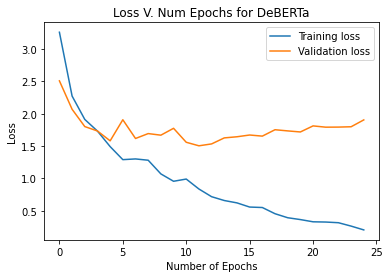

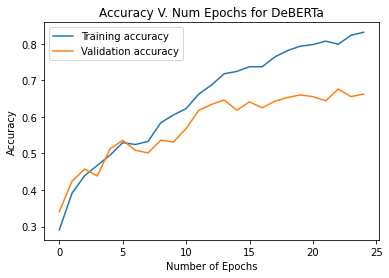

In [13]:
#plotting the training and validation loss
plt.plot(list(range(epochs_trained)), train_loss, label = 'Training loss')
plt.plot(list(range(epochs_trained)), val_loss, label = 'Validation loss')
plt.title("Loss V. Num Epochs for DeBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.plot(list(range(epochs_trained)), train_acc, label = 'Training accuracy')
plt.plot(list(range(epochs_trained)), val_acc, label = 'Validation accuracy')
plt.title("Accuracy V. Num Epochs for DeBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
#testing loop
model.eval()
total_test_loss = 0
total_test_acc = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels, rel_freq_heuristic = batch
    input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_test_loss += loss.item()
        total_test_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

    #deleting unnecessary values to save memory
    del input_ids, attention_mask, labels, outputs, loss

#calculating average test loss
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_acc}")

Test Loss: 1.729627419401098
Test Accuracy: 0.6696428571428571


In [15]:
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

# Save the training and validation loss and accuracy to a pickle file
with open(base_dir + 'loss_acc_deberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_loss, val_loss, train_acc, val_acc), f)
#close file
f.close()

[3.2584196480493697, 2.2722259343616544, 1.9111702016421728, 1.7309575487696935, 1.49137301388241, 1.2897795963855017, 1.3007783322107225, 1.2808377681270477, 1.0693624232496535, 0.9556111336227447, 0.9899223420828108, 0.8360871258709166, 0.7172234242870694, 0.6581077108544017, 0.621633019593973, 0.5572323890787269, 0.5500729511536303, 0.4542997858472287, 0.3921721622584358, 0.36370828052953125, 0.329336847607342, 0.32558540996932794, 0.31518413459083866, 0.26288458622164196, 0.2039365717875106]
[2.5072280830807157, 2.0679926165827998, 1.8007784949408636, 1.7325612041685317, 1.580300227359489, 1.9063677655325995, 1.61673194832272, 1.692413952615526, 1.667933545730732, 1.7740577437259533, 1.558261681486059, 1.5036982010912012, 1.5327904908745378, 1.6257836001890678, 1.643317820849242, 1.6703785724110074, 1.653275657583166, 1.752058936489953, 1.7340291065198403, 1.7175406063044514, 1.8111950799270913, 1.791484660572476, 1.792777528365453, 1.7979724760408755, 1.9039772583378687]
[0.290674